# **Data Import :**

In [10]:
!pip install rasterio --quiet

import os
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 101.2 MB/s eta 0:00:00


In [11]:
from google.colab import files
uploaded = files.upload()

Saving WaterSeg_Data.zip to WaterSeg_Data.zip


In [12]:
import zipfile
import os

# مسار الملف المضغوط (تأكد أنك رفعته)
zip_path = "/content/WaterSeg_Data.zip"
extract_dir = "/content/WaterSeg_Data"

# فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# التأكد من المحتويات
os.listdir(f"{extract_dir}/data")



['images', 'labels']

# **Preprocessing :**

In [13]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# Shared file names
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# Read .tif image (12 channels)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # to (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# Read .png image
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)
Train: (244, 128, 128, 12)
Test: (62, 128, 128, 12)


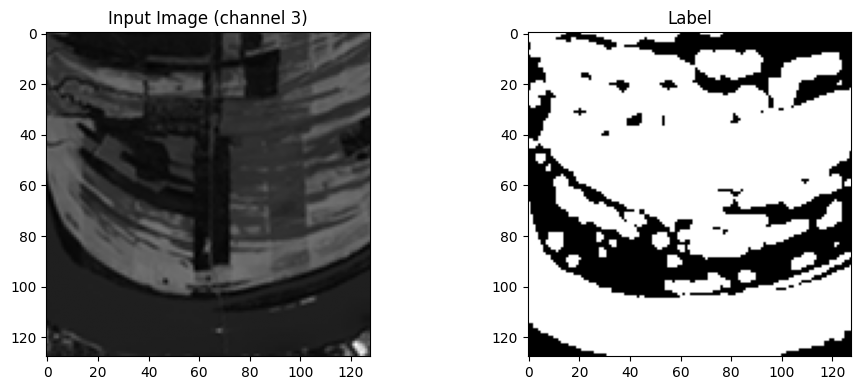

In [14]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# Shared file names
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# Read .tif image (12 channels)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # to (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# Read .png image
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)

# Normalization (channel-wise min-max)
X_min = np.min(X, axis=(0, 1, 2), keepdims=True)
X_max = np.max(X, axis=(0, 1, 2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

# Labels
Y = (Y > 0).astype(np.uint8)

# 80% Training - 20% Testing
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Train:", train_x.shape)
print("Test:", test_x.shape)

def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')
    axs[0].set_title("Input Image (channel 3)")

    label_img = train_y[index]
    if label_img.shape[-1] == 2:
        label_img = np.argmax(label_img, axis=-1)

    axs[1].imshow(label_img, cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)

In [15]:
# Normalization (channel-wise min-max)
X_min = np.min(X, axis=(0, 1, 2), keepdims=True)
X_max = np.max(X, axis=(0, 1, 2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

# Labels
Y = (Y > 0).astype(np.uint8)


In [16]:
# 80% Training - 20% Testing
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Train:", train_x.shape)
print("Test:", test_x.shape)


Train: (244, 128, 128, 12)
Test: (62, 128, 128, 12)


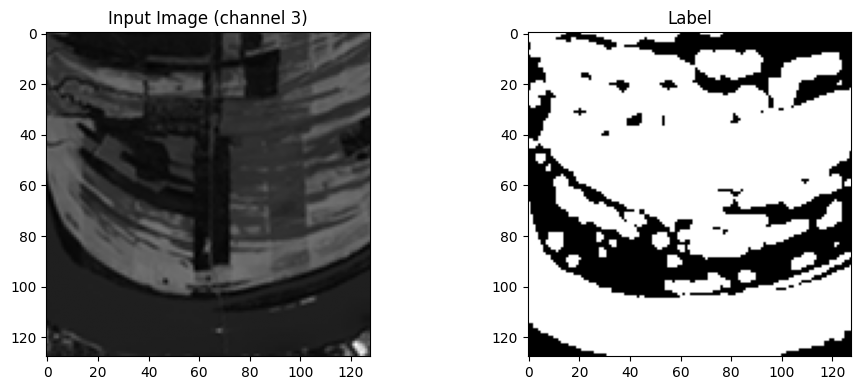

In [17]:
def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')
    axs[0].set_title("Input Image (channel 3)")

    label_img = train_y[index]
    if label_img.shape[-1] == 2:
        label_img = np.argmax(label_img, axis=-1)

    axs[1].imshow(label_img, cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)


# **U-Net Model :**

In [15]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # Bridge
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d3) # A final Conv2D layer with (2 classes: water/background).

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 7,788,097 (29.71 MB)

 Trainable params: 7,788,097 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Define early stopping and reduce_lr & model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint = ModelCheckpoint("best_model_scratch.h5", monitor="val_accuracy", save_best_only=True)


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])


history = model.fit(
    train_x, train_y,
    epochs=80,
    batch_size=8
)


Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 504ms/step - accuracy: 0.6875 - loss: 0.6121
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8290 - loss: 0.4075
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8881 - loss: 0.2936
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8973 - loss: 0.2726
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9070 - loss: 0.2469
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9163 - loss: 0.2352
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9040 - loss: 0.2506
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9092 - loss: 0.2399
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9049 - loss: 0.2534
Epoch 10/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9120 - loss: 0.2297
Epoch 11/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9055 - loss: 0.2418
Epoch 12/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accurac

In [18]:
loss, acc = model.evaluate(train_x, train_y)
print("Train accuracy:", acc)

loss, acc = model.evaluate(test_x, test_y)
print("Test accuracy:", acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9849 - loss: 0.0369
Train accuracy: 0.9849538207054138
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9702 - loss: 0.1110
Test accuracy: 0.9678078889846802


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


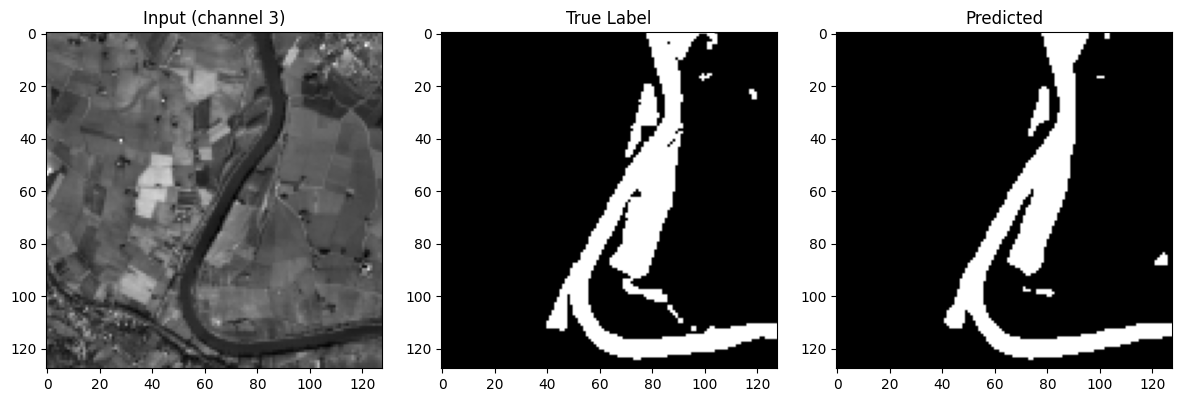

In [19]:
def show_prediction(index):
    image = test_x[index:index+1]  # (1, 128, 128, 12)

    # True label
    label = test_y[index].squeeze()  # (128, 128)

    # Prediction
    pred = model.predict(image)[0]  # (128, 128, 1)
    pred = (pred > 0.5).astype(np.uint8).squeeze()  # Threshold + remove channel dim

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[0][:,:,3], cmap='gray')  # Channel 3 فقط
    axs[0].set_title("Input (channel 3)")
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title("True Label")
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title("Predicted")
    plt.tight_layout()
    plt.show()

show_prediction(0)


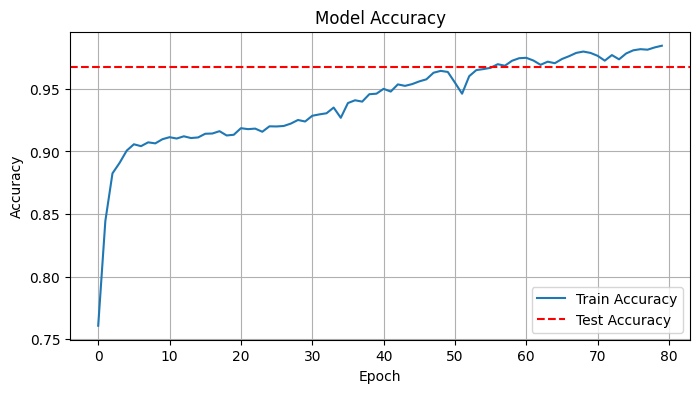

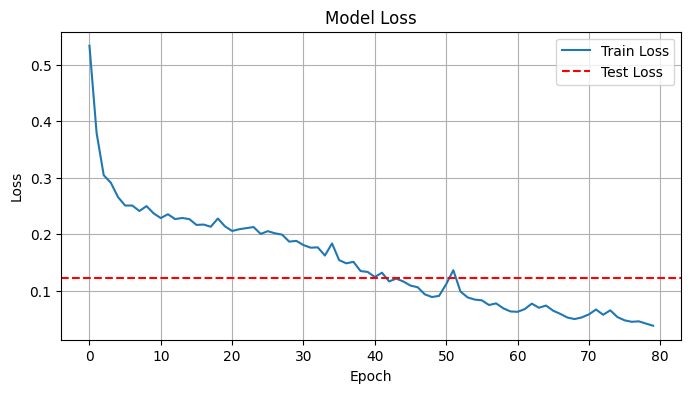

Train Accuracy: 0.9849538207054138
Test Accuracy: 0.9678078889846802
Train Loss: 0.03661388158798218
Test Loss: 0.1218995749950409


In [20]:
train_loss, train_acc = model.evaluate(train_x, train_y, verbose=0)
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)

# 1. Accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Loss plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print values for confirmation
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


In [21]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

#1. Probabilistic Forecasts
y_pred_probs = model.predict(test_x)  # shape = (N, H, W, 1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)  # تحويل إلى 0 أو 1 باستخدام threshold 0.5

# 2. Ground truth
y_true = test_y.astype(np.uint8)  # يفترض أنه بالفعل 0 أو 1

#3. Flatten to 1D to compare each pixel.
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

#4. Evaluation Reports
print("\nClassification Report:\n", classification_report(y_true_flat, y_pred_flat, digits=4))

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
accuracy = accuracy_score(y_true_flat, y_pred_flat)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step

Classification Report:
               precision    recall  f1-score   support

           0     0.9731    0.9858    0.9794    787894
           1     0.9484    0.9058    0.9266    227914

    accuracy                         0.9678   1015808
   macro avg     0.9608    0.9458    0.9530   1015808
weighted avg     0.9676    0.9678    0.9675   1015808

Accuracy:  0.9678
Precision: 0.9484
Recall:    0.9058
F1 Score:  0.9266


In [22]:
import numpy as np

# A function to calculate the IoU between predicted and actual pixels
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # Special case if both are empty

    iou = intersection / union
    return iou

# Predict the model
y_pred_probs = model.predict(test_x)                      # Output: (N, H, W, 1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)            # Apply threshold to get binary mask

# Ground truth
y_true = test_y.astype(np.uint8)                          # Already binary (0 or 1)

# Flatten the results to 1D
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Calculate IoU
iou_score = compute_iou(y_true_flat, y_pred_flat)
print(f"IoU: {iou_score:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
IoU: 0.8633


# **Pre-trained model :  (Preprocessing)**

In [18]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_on_images(images, n_components=3):
    """
    Apply PCA to reduce channels from 12 to 3 on a batch of images.

    Parameters:
    - images: numpy array of shape (num_samples, height, width, 12)
    - n_components: number of channels after reduction

    Returns:
    - reduced_images: numpy array of shape (num_samples, height, width, n_components)
    """
    num_samples, height, width, channels = images.shape
    reduced_images = np.zeros((num_samples, height, width, n_components), dtype=np.float32)

    for i in range(num_samples):
        # reshape from (128,128,12) → (128*128, 12)
        flat_img = images[i].reshape(-1, channels)

        # apply PCA on pixel vectors
        pca = PCA(n_components=n_components)
        flat_reduced = pca.fit_transform(flat_img)

        # reshape back to (128,128,n_components)
        reduced_images[i] = flat_reduced.reshape(height, width, n_components)

    return reduced_images


In [28]:
# نفترض أن train_x هو (N, 128, 128, 12)
train_x_rgb = apply_pca_on_images(train_x, n_components=3)

# نفس الشيء إذا عندك test set
test_x_rgb = apply_pca_on_images(test_x, n_components=3)

In [29]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return 1 - dice


# **Pre-trained model :  (Model Building & Training)**

In [30]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def build_model_with_resnet3(input_shape=(128, 128, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Skip connections
    inputs = base_model.input
    skip1 = base_model.get_layer("conv1_relu").output        # 64x64
    skip2 = base_model.get_layer("conv2_block3_out").output  # 32x32
    skip3 = base_model.get_layer("conv3_block4_out").output  # 16x16
    encoder_output = base_model.get_layer("conv4_block6_out").output  # 8x8

    # Decoder
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding="same", activation='relu')(encoder_output)
    d1 = layers.Concatenate()([d1, skip3])
    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation='relu')(d1)
    d2 = layers.Concatenate()([d2, skip2])
    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(d2)
    d3 = layers.Concatenate()([d3, skip1])
    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(d3)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model

model = build_model_with_resnet3(input_shape=(128,128,3))
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 16,368,513 (62.44 MB)

 Trainable params: 16,337,921 (62.32 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("UNet-REsNet.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9620 - loss: 0.1033

31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 697ms/step - accuracy: 0.9618 - loss: 0.1036 - learning_rate: 0.0010
Epoch 2/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9608 - loss: 0.1010

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9609 - loss: 0.1007 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9543 - loss: 0.1136 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9572 - loss: 0.1074 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9590 - loss: 0.1098 - learning_rate: 0.0010
Epoch 6/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9692 - loss: 0.0783

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9690 - loss: 0.0787 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9658 - loss: 0.0880 - learning_rate: 0.0010
Epoch 8/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9692 - loss: 0.0791

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9691 - loss: 0.0792 - learning_rate: 0.0010
Epoch 9/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9746 - loss: 0.0639

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9744 - loss: 0.0644 - learning_rate: 0.0010
Epoch 10/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9745 - loss: 0.0643

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9744 - loss: 0.0647 - learning_rate: 0.0010
Epoch 11/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9716 - loss: 0.0736

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.9718 - loss: 0.0732 - learning_rate: 0.0010
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9688 - loss: 0.0782 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9289 - loss: 0.1825 - learning_rate: 0.0010
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9527 - loss: 0.1263 - learning_rate: 0.0010
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9595 - loss: 0.1028 - learning_rate: 0.0010
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9696 - loss: 0.0784 - learning_rate: 0.0010
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9708 - loss: 0.0757 - learning_rate: 5.0000e-04
Epoch 18/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9758 - loss: 0.0618

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9759 - loss: 0.0618 - learning_rate: 5.0000e-04
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9772 - loss: 0.0580

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.9771 - loss: 0.0581 - learning_rate: 5.0000e-04
Epoch 20/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9771 - loss: 0.0589

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.9772 - loss: 0.0587 - learning_rate: 5.0000e-04
Epoch 21/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9805 - loss: 0.0500

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.9804 - loss: 0.0502 - learning_rate: 5.0000e-04
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9787 - loss: 0.0535 - learning_rate: 5.0000e-04
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9784 - loss: 0.0547 - learning_rate: 5.0000e-04
Epoch 24/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9805 - loss: 0.0492

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9805 - loss: 0.0492 - learning_rate: 5.0000e-04
Epoch 25/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9805 - loss: 0.0487

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.9806 - loss: 0.0486 - learning_rate: 5.0000e-04
Epoch 26/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9821 - loss: 0.0456

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.9821 - loss: 0.0456 - learning_rate: 5.0000e-04
Epoch 27/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9840 - loss: 0.0408

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9839 - loss: 0.0410 - learning_rate: 5.0000e-04
Epoch 28/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9833 - loss: 0.0422

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - accuracy: 0.9832 - loss: 0.0422 - learning_rate: 5.0000e-04
Epoch 29/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9814 - loss: 0.0467

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.9815 - loss: 0.0464 - learning_rate: 5.0000e-04
Epoch 30/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9816 - loss: 0.0454

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.9817 - loss: 0.0452 - learning_rate: 5.0000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9825 - loss: 0.0440 - learning_rate: 5.0000e-04
Epoch 32/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9852 - loss: 0.0372

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9852 - loss: 0.0373 - learning_rate: 5.0000e-04
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9844 - loss: 0.0391 - learning_rate: 5.0000e-04
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9865 - loss: 0.0335 - learning_rate: 5.0000e-04
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9762 - loss: 0.0613 - learning_rate: 5.0000e-04
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9735 - loss: 0.0709 - learning_rate: 5.0000e-04
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9770 - loss: 0.0592 - learning_rate: 5.0000e-04
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9783 - loss: 0.0556 - learning_rate: 2.5000e-04
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9826 - loss: 0.0448 - learning_rate: 2.5000e-04
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9841 - loss: 0.0413 - learning_ra

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.9853 - loss: 0.0373 - learning_rate: 2.5000e-04
Epoch 42/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9853 - loss: 0.0372

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9854 - loss: 0.0372 - learning_rate: 2.5000e-04
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9856 - loss: 0.0365 - learning_rate: 2.5000e-04
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9853 - loss: 0.0385 - learning_rate: 2.5000e-04
Epoch 45/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9861 - loss: 0.0351

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.9861 - loss: 0.0351 - learning_rate: 2.5000e-04
Epoch 46/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9865 - loss: 0.0342

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.9865 - loss: 0.0341 - learning_rate: 2.5000e-04
Epoch 47/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9864 - loss: 0.0353

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9865 - loss: 0.0351 - learning_rate: 2.5000e-04
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9886 - loss: 0.0293 - learning_rate: 2.5000e-04
Epoch 49/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9875 - loss: 0.0324

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.9876 - loss: 0.0322 - learning_rate: 2.5000e-04
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9898 - loss: 0.0261 - learning_rate: 2.5000e-04


In [37]:
# تقييم الأداء على بيانات التدريب
train_loss, train_acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", round(train_acc * 100, 2), "%")
print("Train Loss:", round(train_loss, 4))

# تقييم الأداء على بيانات الاختبار
test_loss, test_acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", round(test_acc * 100, 2), "%")
print("Test Loss:", round(test_loss, 4))


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.9900 - loss: 0.0261
Train Accuracy: 98.99 %
Train Loss: 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9188 - loss: 0.3762
Test Accuracy: 91.29 %
Test Loss: 0.4116


**bce_dice_loss**

In [38]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])


history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("UNet-REsNet-bce;.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9831 - loss: 0.0872

31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 790ms/step - accuracy: 0.9830 - loss: 0.0874 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9794 - loss: 0.1060 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9809 - loss: 0.0972 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9809 - loss: 0.1023 - learning_rate: 0.0010
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9843 - loss: 0.0873

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.9843 - loss: 0.0873 - learning_rate: 0.0010
Epoch 6/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9823 - loss: 0.0904

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.9825 - loss: 0.0899 - learning_rate: 0.0010
Epoch 7/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9863 - loss: 0.0722

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.9863 - loss: 0.0722 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9872 - loss: 0.0739 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9730 - loss: 0.1516 - learning_rate: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9761 - loss: 0.1407 - learning_rate: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9790 - loss: 0.1118 - learning_rate: 0.0010
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9848 - loss: 0.0816 - learning_rate: 0.0010
Epoch 13/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9878 - loss: 0.0679

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.9878 - loss: 0.0676 - learning_rate: 5.0000e-04
Epoch 14/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9888 - loss: 0.0600

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9889 - loss: 0.0598 - learning_rate: 5.0000e-04
Epoch 15/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9906 - loss: 0.0498

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9906 - loss: 0.0499 - learning_rate: 5.0000e-04
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9913 - loss: 0.0505 - learning_rate: 5.0000e-04
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9913 - loss: 0.0489 - learning_rate: 5.0000e-04
Epoch 18/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9911 - loss: 0.0503

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9911 - loss: 0.0501 - learning_rate: 5.0000e-04
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9927 - loss: 0.0416

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9926 - loss: 0.0419 - learning_rate: 5.0000e-04
Epoch 20/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9917 - loss: 0.0443

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.9917 - loss: 0.0443 - learning_rate: 5.0000e-04
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9919 - loss: 0.0439 - learning_rate: 5.0000e-04
Epoch 22/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9918 - loss: 0.0428

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.9919 - loss: 0.0427 - learning_rate: 5.0000e-04
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9929 - loss: 0.0384 - learning_rate: 5.0000e-04
Epoch 24/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9937 - loss: 0.0347

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.9937 - loss: 0.0350 - learning_rate: 5.0000e-04
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9933 - loss: 0.0373 - learning_rate: 5.0000e-04
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9931 - loss: 0.0360 - learning_rate: 5.0000e-04
Epoch 27/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9931 - loss: 0.0367

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.9931 - loss: 0.0368 - learning_rate: 5.0000e-04
Epoch 28/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9944 - loss: 0.0326

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.9943 - loss: 0.0328 - learning_rate: 5.0000e-04
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9947 - loss: 0.0303 - learning_rate: 5.0000e-04
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9926 - loss: 0.0380 - learning_rate: 5.0000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9935 - loss: 0.0359 - learning_rate: 5.0000e-04
Epoch 32/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9941 - loss: 0.0327

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.9941 - loss: 0.0328 - learning_rate: 5.0000e-04
Epoch 33/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9937 - loss: 0.0340

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.9937 - loss: 0.0340 - learning_rate: 5.0000e-04
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9949 - loss: 0.0295

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9949 - loss: 0.0295 - learning_rate: 5.0000e-04
Epoch 35/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9948 - loss: 0.0292

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9948 - loss: 0.0292 - learning_rate: 5.0000e-04
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9936 - loss: 0.0361 - learning_rate: 5.0000e-04
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9893 - loss: 0.0718 - learning_rate: 5.0000e-04
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9919 - loss: 0.0452 - learning_rate: 5.0000e-04
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9939 - loss: 0.0343 - learning_rate: 5.0000e-04
Epoch 40/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9941 - loss: 0.0336

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.9942 - loss: 0.0333 - learning_rate: 5.0000e-04
Epoch 41/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9952 - loss: 0.0266

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.9952 - loss: 0.0266 - learning_rate: 5.0000e-04
Epoch 42/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9955 - loss: 0.0240

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.9955 - loss: 0.0240 - learning_rate: 5.0000e-04
Epoch 43/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9958 - loss: 0.0234

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9958 - loss: 0.0235 - learning_rate: 5.0000e-04
Epoch 44/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9956 - loss: 0.0242

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9956 - loss: 0.0241 - learning_rate: 5.0000e-04
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9961 - loss: 0.0241 - learning_rate: 5.0000e-04
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9955 - loss: 0.0261 - learning_rate: 5.0000e-04
Epoch 47/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9960 - loss: 0.0221

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9960 - loss: 0.0221 - learning_rate: 5.0000e-04
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9965 - loss: 0.0205 - learning_rate: 5.0000e-04
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9961 - loss: 0.0232 - learning_rate: 5.0000e-04
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9962 - loss: 0.0226 - learning_rate: 5.0000e-04


In [39]:
loss, acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", acc)

loss, acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.9971 - loss: 0.0170
Train Accuracy: 0.9970285296440125
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9226 - loss: 0.7963
Test Accuracy: 0.9163306355476379


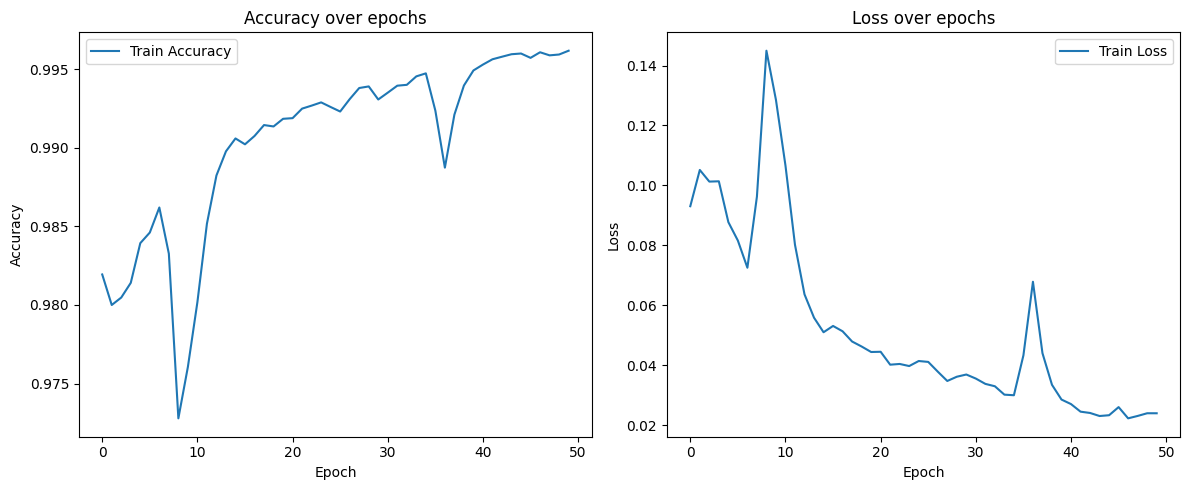

In [40]:
import matplotlib.pyplot as plt

# رسم منحنى الدقة
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Adding CNN layer before Pretrained model & Using bce**

In [33]:
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K

# ---------- Step 1: Apply PCA to reduce 12 channels → 3 ----------
def apply_pca_on_images(images, n_components=3):
    num_samples, height, width, channels = images.shape
    reduced_images = np.zeros((num_samples, height, width, n_components), dtype=np.float32)

    for i in range(num_samples):
        flat_img = images[i].reshape(-1, channels)
        pca = PCA(n_components=n_components)
        flat_reduced = pca.fit_transform(flat_img)
        reduced_images[i] = flat_reduced.reshape(height, width, n_components)

    return reduced_images

# Apply PCA
train_x_rgb = apply_pca_on_images(train_x, n_components=3)
test_x_rgb = apply_pca_on_images(test_x, n_components=3)

# ---------- Step 2: Define Dice + BCE Loss ----------
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# ---------- Step 3: Build Model with Pretrained ResNet50 ----------
def build_model_with_resnet3_pca(input_shape=(128, 128, 3)):
    input_tensor = layers.Input(shape=input_shape)

    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
    skip1 = base_model.get_layer("conv1_relu").output
    skip2 = base_model.get_layer("conv2_block3_out").output
    skip3 = base_model.get_layer("conv3_block4_out").output
    encoder_output = base_model.get_layer("conv4_block6_out").output

    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding="same", activation='relu')(encoder_output)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Concatenate()([d1, skip3])

    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation='relu')(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Concatenate()([d2, skip2])

    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Concatenate()([d3, skip1])

    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(d3)
    d4 = layers.BatchNormalization()(d4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    model = models.Model(inputs=input_tensor, outputs=outputs)
    return model

# ---------- Step 4: Compile and Train ----------
model = build_model_with_resnet3_pca(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_15[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 16,372,353 (62.46 MB)

 Trainable params: 16,339,841 (62.33 MB)

 Non-trainable params: 32,512 (127.00 KB)

In [34]:
history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("UNet-ResNet-best.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=3),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=8, restore_best_weights=True)
    ]
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7103 - loss: 1.1486 - mean_io_u_6: 0.3604  

31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7124 - loss: 1.1443 - mean_io_u_6: 0.3612 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8064 - loss: 0.9290 - mean_io_u_6: 0.4365

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8068 - loss: 0.9276 - mean_io_u_6: 0.4363 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8162 - loss: 0.8250 - mean_io_u_6: 0.4151

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8161 - loss: 0.8265 - mean_io_u_6: 0.4152 - learning_rate: 0.0010
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8182 - loss: 0.8022 - mean_io_u_6: 0.3702

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8190 - loss: 0.8021 - mean_io_u_6: 0.3723 - learning_rate: 0.0010
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8590 - loss: 0.7547 - mean_io_u_6: 0.4525

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8579 - loss: 0.7565 - mean_io_u_6: 0.4508 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8541 - loss: 0.6794 - mean_io_u_6: 0.4269

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8539 - loss: 0.6801 - mean_io_u_6: 0.4267 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8653 - loss: 0.7105 - mean_io_u_6: 0.4398 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8430 - loss: 0.7511 - mean_io_u_6: 0.3979

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8436 - loss: 0.7488 - mean_io_u_6: 0.3979 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8768 - loss: 0.6648 - mean_io_u_6: 0.4594

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8768 - loss: 0.6637 - mean_io_u_6: 0.4584 - learning_rate: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8807 - loss: 0.6161 - mean_io_u_6: 0.4380 - learning_rate: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8900 - loss: 0.5689 - mean_io_u_6: 0.4006

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8900 - loss: 0.5693 - mean_io_u_6: 0.4005 - learning_rate: 0.0010
Epoch 12/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9109 - loss: 0.4911 - mean_io_u_6: 0.4173

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9105 - loss: 0.4906 - mean_io_u_6: 0.4175 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9117 - loss: 0.4970 - mean_io_u_6: 0.4344 - learning_rate: 0.0010
Epoch 14/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9007 - loss: 0.5155 - mean_io_u_6: 0.4166

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9012 - loss: 0.5130 - mean_io_u_6: 0.4167 - learning_rate: 0.0010
Epoch 15/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9193 - loss: 0.4607 - mean_io_u_6: 0.4469

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9191 - loss: 0.4602 - mean_io_u_6: 0.4451 - learning_rate: 0.0010
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9246 - loss: 0.3869 - mean_io_u_6: 0.4120

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9247 - loss: 0.3872 - mean_io_u_6: 0.4127 - learning_rate: 0.0010
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9318 - loss: 0.3760 - mean_io_u_6: 0.4152 - learning_rate: 0.0010
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9328 - loss: 0.3693 - mean_io_u_6: 0.4164

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9327 - loss: 0.3696 - mean_io_u_6: 0.4167 - learning_rate: 0.0010
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9314 - loss: 0.3811 - mean_io_u_6: 0.4227 - learning_rate: 0.0010
Epoch 20/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9378 - loss: 0.3411 - mean_io_u_6: 0.4154

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9377 - loss: 0.3419 - mean_io_u_6: 0.4155 - learning_rate: 0.0010
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9541 - loss: 0.2742 - mean_io_u_6: 0.4497

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9539 - loss: 0.2743 - mean_io_u_6: 0.4490 - learning_rate: 0.0010
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9478 - loss: 0.2811 - mean_io_u_6: 0.4378 - learning_rate: 0.0010
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9361 - loss: 0.3438 - mean_io_u_6: 0.4518 - learning_rate: 0.0010
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9406 - loss: 0.3349 - mean_io_u_6: 0.4221 - learning_rate: 0.0010
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9465 - loss: 0.2838 - mean_io_u_6: 0.3969

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9468 - loss: 0.2827 - mean_io_u_6: 0.3974 - learning_rate: 3.0000e-04
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9567 - loss: 0.2351 - mean_io_u_6: 0.4154 - learning_rate: 3.0000e-04
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9648 - loss: 0.1945 - mean_io_u_6: 0.4144

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9649 - loss: 0.1943 - mean_io_u_6: 0.4145 - learning_rate: 3.0000e-04
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9667 - loss: 0.2178 - mean_io_u_6: 0.4595 - learning_rate: 3.0000e-04
Epoch 29/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9721 - loss: 0.1611 - mean_io_u_6: 0.4474

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9720 - loss: 0.1616 - mean_io_u_6: 0.4467 - learning_rate: 3.0000e-04
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9691 - loss: 0.1625 - mean_io_u_6: 0.4285

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9691 - loss: 0.1624 - mean_io_u_6: 0.4291 - learning_rate: 3.0000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.9719 - loss: 0.1829 - mean_io_u_6: 0.4348 - learning_rate: 3.0000e-04
Epoch 32/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9730 - loss: 0.1460 - mean_io_u_6: 0.4194

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9731 - loss: 0.1462 - mean_io_u_6: 0.4208 - learning_rate: 3.0000e-04
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9734 - loss: 0.1561 - mean_io_u_6: 0.4273 - learning_rate: 3.0000e-04
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9754 - loss: 0.1368 - mean_io_u_6: 0.4441 - learning_rate: 3.0000e-04
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9735 - loss: 0.1736 - mean_io_u_6: 0.4738

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9736 - loss: 0.1726 - mean_io_u_6: 0.4728 - learning_rate: 3.0000e-04
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9777 - loss: 0.1252 - mean_io_u_6: 0.4362

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9777 - loss: 0.1253 - mean_io_u_6: 0.4369 - learning_rate: 3.0000e-04
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9773 - loss: 0.1325 - mean_io_u_6: 0.4733 - learning_rate: 3.0000e-04
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9765 - loss: 0.1453 - mean_io_u_6: 0.4596 - learning_rate: 3.0000e-04
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9807 - loss: 0.1150 - mean_io_u_6: 0.4352

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9807 - loss: 0.1152 - mean_io_u_6: 0.4361 - learning_rate: 3.0000e-04
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9746 - loss: 0.1846 - mean_io_u_6: 0.4753 - learning_rate: 3.0000e-04
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9744 - loss: 0.1509 - mean_io_u_6: 0.4147 - learning_rate: 3.0000e-04
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9806 - loss: 0.1118 - mean_io_u_6: 0.4736

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9806 - loss: 0.1117 - mean_io_u_6: 0.4731 - learning_rate: 3.0000e-04
Epoch 43/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9815 - loss: 0.1148 - mean_io_u_6: 0.4859

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9815 - loss: 0.1143 - mean_io_u_6: 0.4843 - learning_rate: 3.0000e-04
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9844 - loss: 0.0852 - mean_io_u_6: 0.4618

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9844 - loss: 0.0854 - mean_io_u_6: 0.4623 - learning_rate: 3.0000e-04
Epoch 45/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9845 - loss: 0.0834 - mean_io_u_6: 0.4788

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9846 - loss: 0.0835 - mean_io_u_6: 0.4789 - learning_rate: 3.0000e-04
Epoch 46/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9851 - loss: 0.0808 - mean_io_u_6: 0.4419

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9851 - loss: 0.0809 - mean_io_u_6: 0.4446 - learning_rate: 3.0000e-04
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9846 - loss: 0.1067 - mean_io_u_6: 0.4839 - learning_rate: 3.0000e-04
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9854 - loss: 0.0898 - mean_io_u_6: 0.4637 - learning_rate: 3.0000e-04
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9841 - loss: 0.0925 - mean_io_u_6: 0.4328 - learning_rate: 3.0000e-04
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9839 - loss: 0.1014 - mean_io_u_6: 0.4525 - learning_rate: 9.0000e-05


In [35]:
from sklearn.metrics import classification_report
import numpy as np

# -------- Evaluate on Training Data --------
train_loss, train_acc, train_iou = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", train_acc)
print("Train IoU:", train_iou)

# -------- Evaluate on Testing Data --------
test_loss, test_acc, test_iou = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", test_acc)
print("Test IoU:", test_iou)

# -------- Classification Report on Test Data --------
# Step 1: Predict masks
y_pred_test = model.predict(test_x_rgb)
y_pred_test_bin = (y_pred_test > 0.5).astype(np.uint8)  # Threshold

# Step 2: Flatten for classification report
y_true_flat = test_y.flatten()
y_pred_flat = y_pred_test_bin.flatten()

# Step 3: Report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_flat, y_pred_flat, target_names=["Background", "Water"]))


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9866 - loss: 0.0742 - mean_io_u_6: 0.4511
Train Accuracy: 0.9864702224731445
Train IoU: 0.44024303555488586
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9240 - loss: 0.5047 - mean_io_u_6: 0.4452
Test Accuracy: 0.9180209040641785
Test IoU: 0.43356215953826904
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

Classification Report on Test Set:
              precision    recall  f1-score   support

  Background       0.92      0.97      0.95    787894
       Water       0.89      0.72      0.80    227914

    accuracy                           0.92   1015808
   macro avg       0.91      0.85      0.87   1015808
weighted avg       0.92      0.92      0.91   1015808



# **Deployment usins Flask API**